In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as sma
import pmdarima
import datetime
import matplotlib
import pytest

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt, exp

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

sns.set_style('whitegrid')

from src.data.dataset_generator import DatasetGenerator
from src.data.data_transformer import DataTransformer

# 1. Reading in the Data from the API

Download the Data (Montel Data & Weather Data; Entsoe Data is still missing)

In [3]:
dg = DatasetGenerator(['all'])
dataset_latest = dg.get_dataset('2016-01-01', 'latest', 'ignored')

Repaired missing montel data from dates: ['2021-03-28']
Data coverage 100%


# 2. Data Preprocessing

Set datetime as index of the dataframe and display the length and timerange of the downloaded dataset.

In [4]:
# Extract Length, and Timerange of the Downloaded Dataset
X = dataset_latest.Time

datapoints = X.index.max()
date_min = X.min()
date_max = X.max()

print('Number of datapoints in the Dataset: {}'.format(datapoints))
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))

# Change Index from Dataframe (new index: Time)
data_hourly = dataset_latest.set_index('Time')
data_hourly.index = pd.date_range(date_min,date_max,freq='H')

Number of datapoints in the Dataset: 49031
Minimum date from data set: 2016-01-01 00:00:00
Maximum date from data set: 2021-08-04 23:00:00


## 2.1 Display Data Characteristics

In [5]:
data_hourly

,SPOTPrice,temp,dwpt,rhum,prcp,wspd,pres,tsun
2016-01-01 00:00:00,23.86,5.2,4.9,98.0,0.1,1.4,1026.6,0.0
2016-01-01 01:00:00,22.39,4.7,4.6,99.0,0.0,3.2,1026.4,0.0
2016-01-01 02:00:00,20.59,3.8,3.7,99.0,0.5,4.3,1026.9,0.0
2016-01-01 03:00:00,16.81,4.0,3.9,99.0,0.5,4.0,1027.4,0.0
2016-01-01 04:00:00,17.41,4.0,3.9,99.0,0.6,4.0,1027.5,0.0
...,...,...,...,...,...,...,...,...
2021-08-04 19:00:00,128.83,15.3,13.0,86.0,1.3,9.3,1012.7,1.0
2021-08-04 20:00:00,123.92,14.8,13.2,90.0,1.6,7.4,1012.8,1.0
2021-08-04 21:00:00,110.09,14.8,13.2,90.0,1.6,7.4,1012.8,1.0
2021-08-04 22:00:00,99.22,14.8,13.2,90.0,1.6,7.4,1012.8,1.0


In [6]:
data_hourly.describe()

,SPOTPrice,temp,dwpt,rhum,prcp,wspd,pres,tsun
count,49032.000000,49032.000000,49032.000000,49032.000000,49032.000000,49032.000000,49032.000000,49032.000000
mean,37.863274,10.728208,5.150757,71.637155,0.112139,10.114353,1017.347169,13.626050
std,19.533669,8.268150,6.627027,18.350351,0.663158,5.645136,8.632064,22.767367
min,-130.090000,-13.900000,-17.500000,15.000000,0.000000,0.000000,982.000000,0.000000
25%,27.127500,4.200000,-0.100000,58.000000,0.000000,6.100000,1012.300000,0.000000
50%,36.200000,10.400000,4.900000,76.000000,0.000000,8.600000,1017.400000,0.000000
75%,47.522500,16.800000,10.900000,87.000000,0.000000,12.600000,1022.400000,22.000000
max,200.040000,35.800000,20.700000,100.000000,37.500000,49.000000,1047.100000,60.000000


## 2.3 Extract each Feature from the Dataframe

Each Feature of the Dataframe is extracted as Pandas Series

In [7]:
data_spot = data_hourly.SPOTPrice
data_temp = data_hourly.temp
data_dwpt = data_hourly.dwpt
data_rhum = data_hourly.rhum
data_prcp = data_hourly.prcp
data_wspd = data_hourly.wspd
data_pres = data_hourly.pres
data_tsun = data_hourly.tsun

## 2.4 Create Spotprice Datasets with different length (Final Week excluded)

For testing univariant spot price forecasting, subdivide the whole dataset into datasets with the following lengths \
(final week is excluded for the model evaluation; will be changed for a better quality in evaluation):
* previous 5 and 1 year/-s
* previous 6, 3 and 1 month/-s
* previous 3, 2 and 1 week/-s
* previous 5, 4, 3, 2 and 1 day/-s

In [36]:
# Testing set for Walk Forward Evaluation (+1h and +24h)
df_test = data_spot.iloc[-169:]
# Training and Validation Sets for Model Training and Hyperparameter Tuning
df_all = data_spot.iloc[:-169]
df_5a = data_spot.iloc[38568:-169]
df_1a = data_spot.iloc[73632:-169]
df_6m = data_spot.iloc[-4512:-169]
df_3m = data_spot.iloc[-2304:-169]
df_1m = data_spot.iloc[-912:-169]
df_3w = data_spot.iloc[-672:-169]
df_2w = data_spot.iloc[-504:-169]
df_1w = data_spot.iloc[-336:-169]
df_5d = data_spot.iloc[-288:-169]
df_4d = data_spot.iloc[-264:-169]
df_3d = data_spot.iloc[-240:-169]
df_2d = data_spot.iloc[-216:-169]
df_1d = data_spot.iloc[-192:-169]

## 2.5 Create Mean Spotprice Datasets with different Means (Daily, Weekly, Monthly)

In [9]:
data_daily = data_spot.resample('1D').mean()

data_weekly = data_spot.resample('1W').mean()

data_monthly = data_spot.resample('1M').mean()

# 3. Data Visualization

## 3.1 Seasonal Decomposition

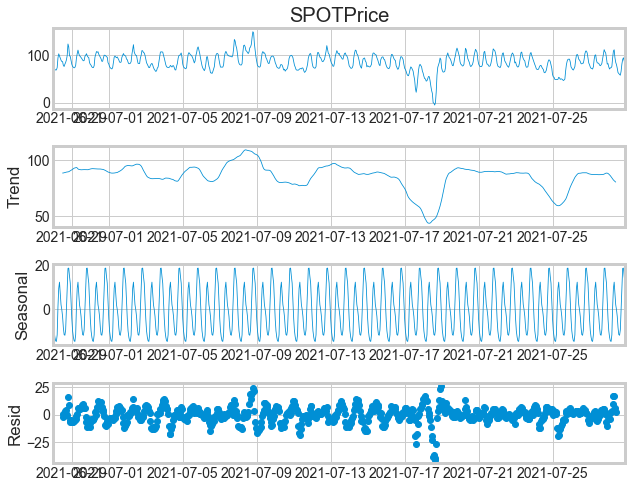

In [13]:
mpl.rcParams['figure.figsize'] = 9, 7
mpl.rcParams['lines.linewidth'] = 0.8
decomposition = seasonal_decompose(df_1m, period=24)
fig = decomposition.plot()
plt.show()

## 3.2 ACF & PACF

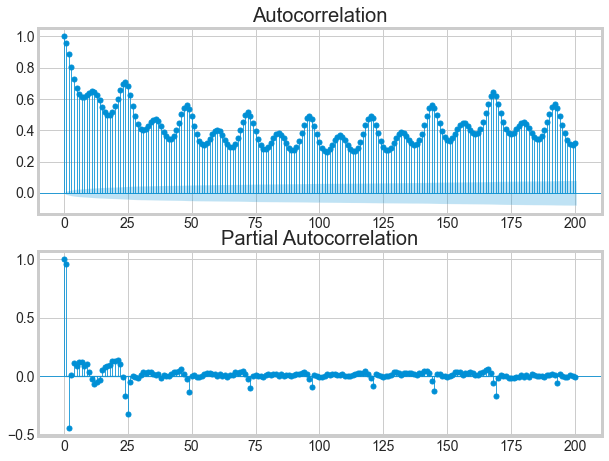

In [16]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(data_spot, lags=200, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(data_spot, lags=200, ax=ax[1])
plt.show()

## 3.3 Plot Data

### 3.3.1 Plot Mean Data

Text(0.5, 1.0, 'EEX Day-Ahead Market')

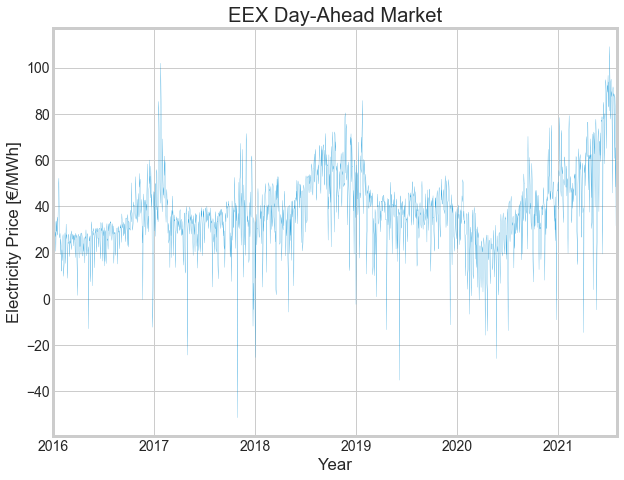

In [24]:
ax = data_daily.plot(linewidth=0.2)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

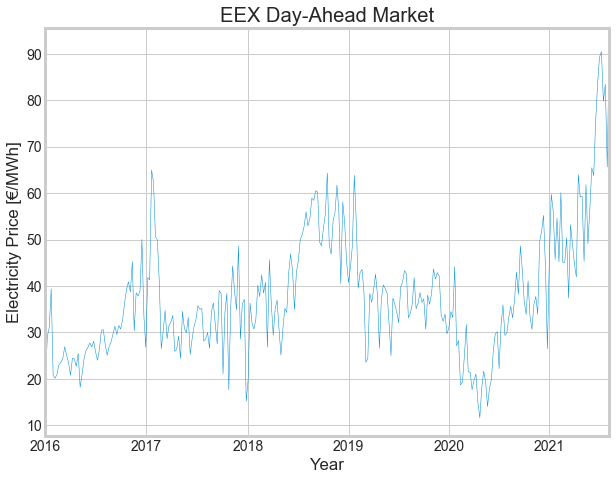

In [25]:
ax = data_weekly.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

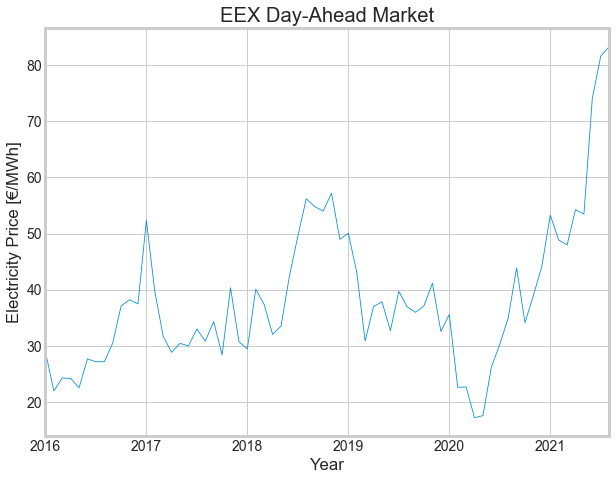

In [26]:
ax = data_monthly.plot(linewidth=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

### 3.3.2 Plot Hourly Data

Text(0.5, 1.0, 'EEX Day-Ahead Market')

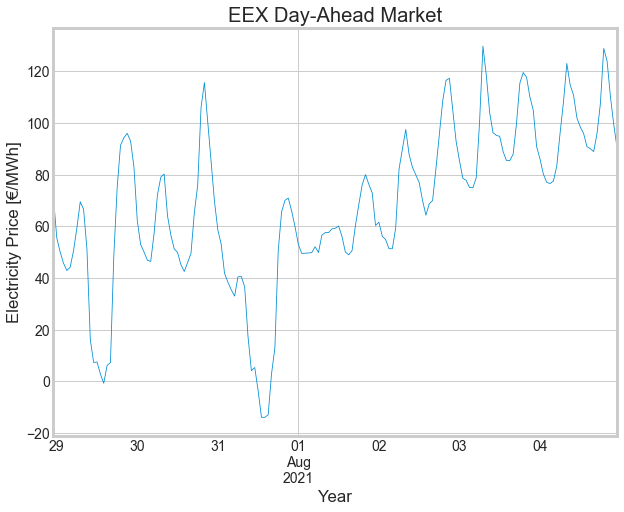

In [33]:
# The data of the last week is used as the test set for the Statistical Models
ax = df_test.plot(linewidth=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

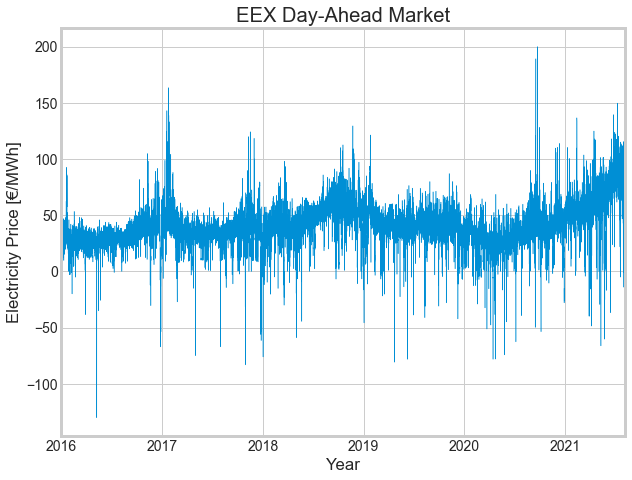

In [34]:
# Whole dataset
ax = data_spot.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

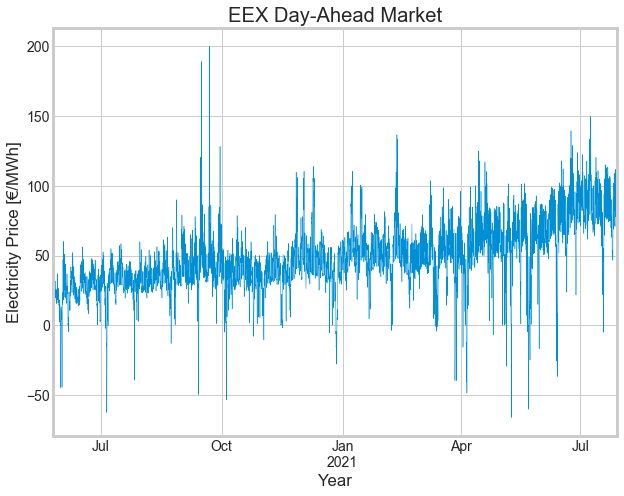

In [29]:
# Previous 5 years
ax = df_5a.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

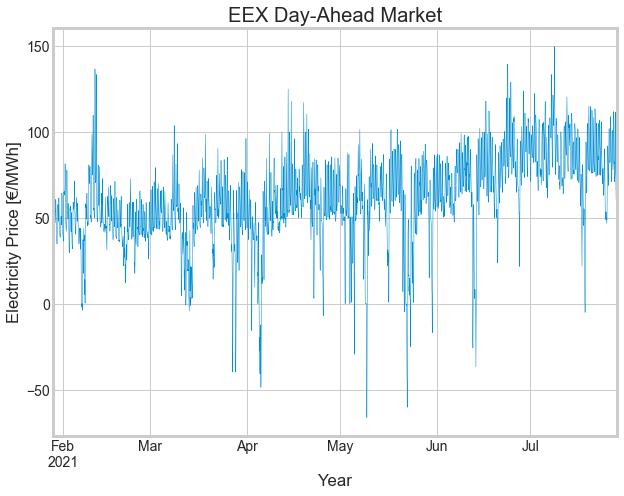

In [39]:
# Previous year
ax = df_6m.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

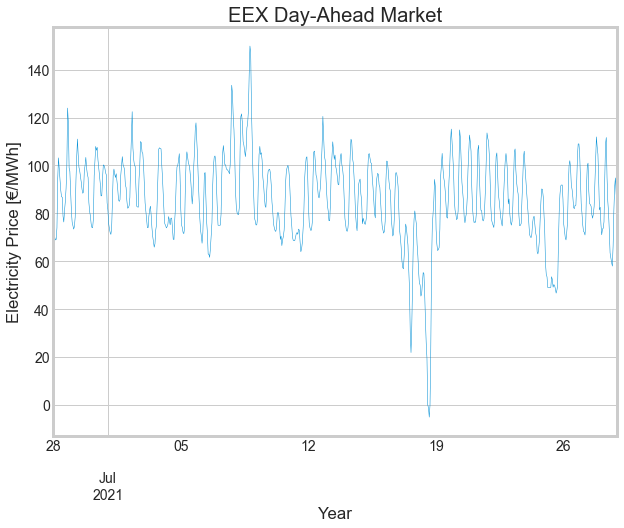

In [40]:
# Previous one month
ax = df_1m.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

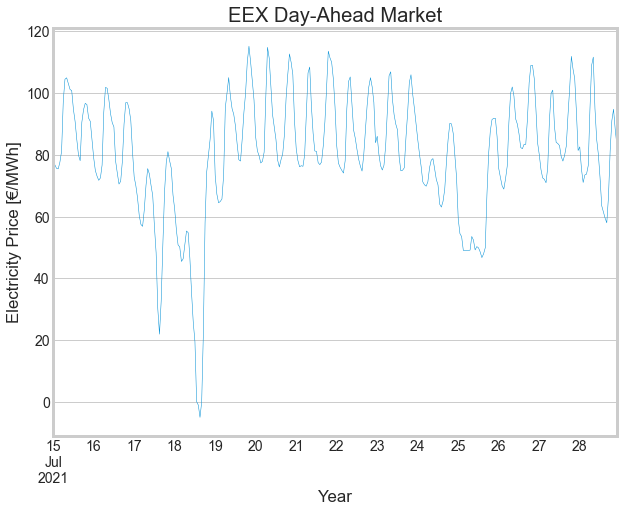

In [41]:
# Previous 2 weeks
ax = df_2w.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

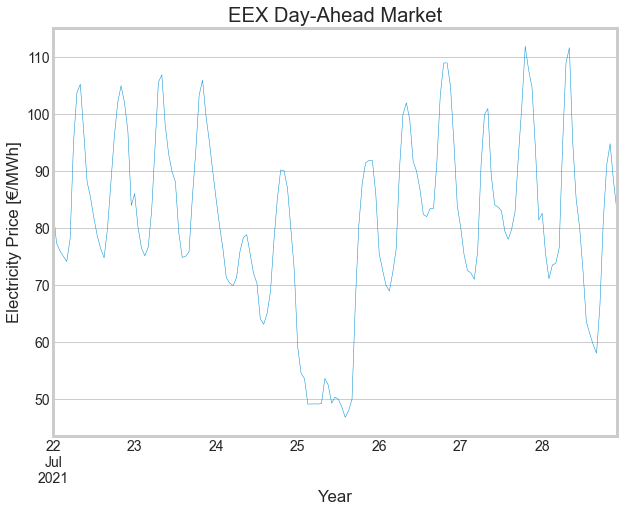

In [42]:
# Previous week
ax = df_1w.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

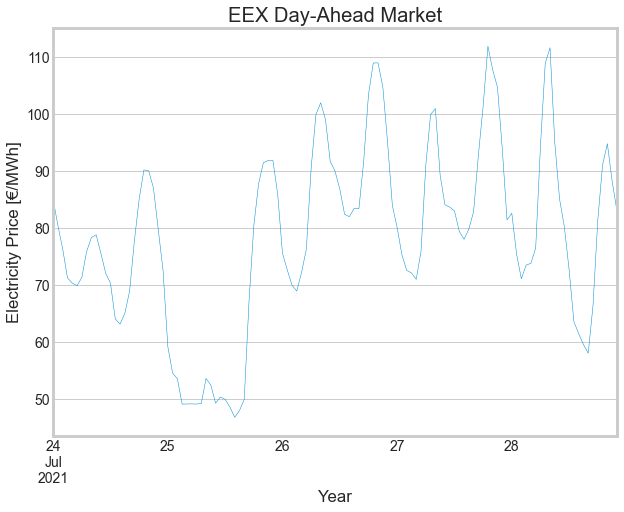

In [44]:
# Previous 5 days
ax = df_5d.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

Text(0.5, 1.0, 'EEX Day-Ahead Market')

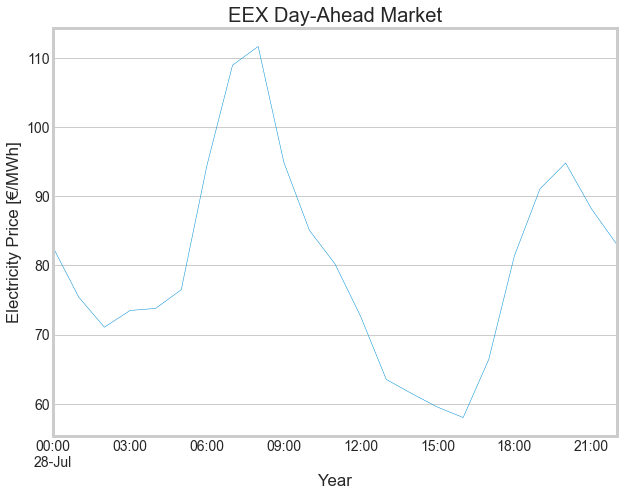

In [45]:
# Previous day
ax = df_1d.plot(linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

# 4. Tests for Stationarity, Seasonality and other Characteristics for TSF

## 4.1 Augmented Dickey-Fuller (ADF) test

In [17]:
nonst_test = sma.adfuller(data_spot)

output = pd.Series(nonst_test[0:4], index=['t-statistic','p-value','lags-used','no-of-observations'])
for key,value in nonst_test[4].items():
    output['Critical Value (%s)'%key] = value
    
print(output)

t-statistic            -1.346455e+01
p-value                 3.476983e-25
lags-used               5.700000e+01
no-of-observations      4.897400e+04
Critical Value (1%)    -3.430484e+00
Critical Value (5%)    -2.861599e+00
Critical Value (10%)   -2.566801e+00
dtype: float64


t-statistic               -33.492281
p-value                     0.000000
lags-used                  55.000000
no-of-observations      46340.000000
Critical Value (1%)        -3.430491
Critical Value (5%)        -2.861602
Critical Value (10%)       -2.566803
dtype: float64


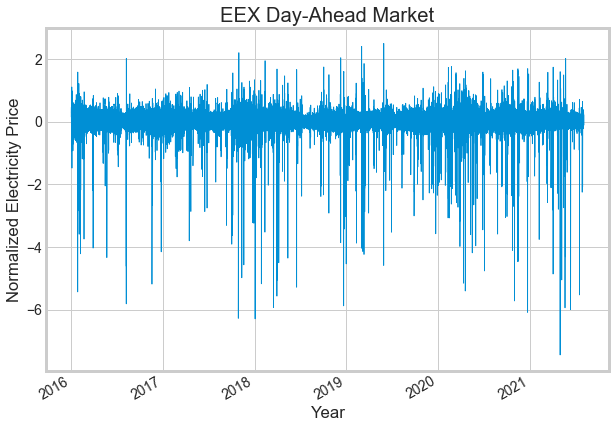

In [19]:
log_data = np.log(data_spot) # Taking the log
ma_data = log_data.rolling(window=12).mean() # Taking moving average
log_minus_ma_data = log_data - ma_data
log_minus_ma_data.dropna(inplace=True)

ax = log_minus_ma_data.plot(linewidth = 0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Electricity Price')
ax.set_title('EEX Day-Ahead Market')

st_test = sma.adfuller(log_minus_ma_data)

output = pd.Series(st_test[0:4], index=['t-statistic','p-value','lags-used','no-of-observations'])
for key,value in st_test[4].items():
    output['Critical Value (%s)'%key] = value
    
print(output)

## 4.2 PP test

In [20]:
test = pmdarima.arima.PPTest()
test.should_diff(data_spot)

(0.01, False)

In [21]:
test.should_diff(log_minus_ma_data)

(0.01, False)

## 4.3 CH Test (Test for seasonal differences)

In [22]:
results = pmdarima.arima.CHTest(m=24).estimate_seasonal_differencing_term(data_spot)
print(results)

1


## 4.4 OCSB Test (Test for Seasonal differencing D)

In [23]:
results = pmdarima.arima.OCSBTest(m=12).estimate_seasonal_differencing_term(data_spot)
print(results)

0
